In [1]:
import torch
import matplotlib.pyplot as plt
from mlrg.hmc import HMCSampler
from rgflow import RGLayer

### Phi4 Model Sampling

In [2]:
class Phi4Model(torch.nn.Module):
    ''' phi4 model energy 
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2 + (u/4) sum_i |x_i|^4
        
        Parameters:
            r :: real - (initial) value of r
            u :: real - (initial) value of u '''
    def __init__(self, r=0., u=1.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.u = torch.nn.Parameter(torch.tensor(u))
        
    def extra_repr(self):
        return f'r={self.r.item()}, u={self.u.item()}'
        
    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl
        
    def forward(self, x):
        energy = 0.
        for axis in range(2, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + self.r * x2 / 2 + self.u * x2.square() / 4
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [71]:
mdl = Phi4Model().requires_grad_(False)
for p in mdl.parameters():
    print(p)

Parameter containing:
tensor(0.)
Parameter containing:
tensor(1.)


In [173]:
hmc = HMCSampler(Phi4Model(r=-1.), [5,1,64,64])

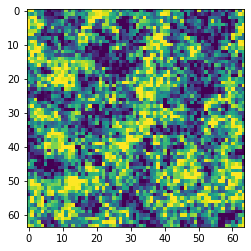

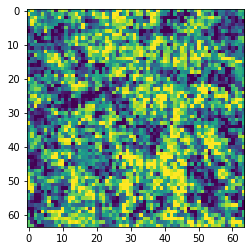

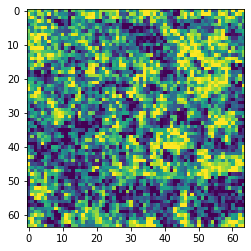

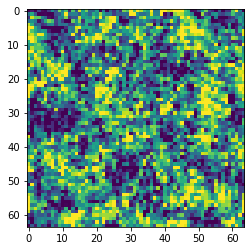

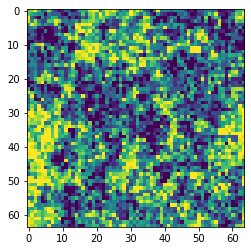

In [175]:
for x in hmc.sample():
    plt.figure()
    plt.imshow(x.squeeze(), vmin=-1, vmax=1)

### RG Layer Demo

In [31]:
hmc = HMCSampler(Phi4Model(r=-1.), [3,1,8,8])

In [193]:
rg = RGLayer([8, 8], 1)

In [200]:
x = hmc.sample()

In [201]:
y, z = rg.encode(x)

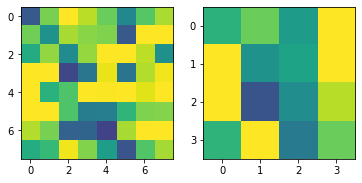

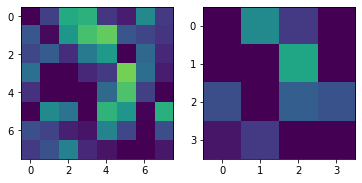

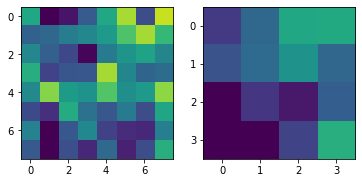

In [202]:
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().squeeze(), vmin=-1, vmax=1)

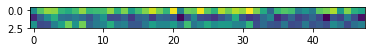

In [208]:
plt.imshow(z.detach().squeeze())

### RG Learner

In [98]:
class RGLearner(torch.nn.Module):
    def __init__(self, uv_model, uv_shape, dim, base_dist='Normal', **kwargs):
        super().__init__()
        self.uv_model = uv_model.requires_grad_(False)
        self.ir_model = uv_model.clone().requires_grad_(True)
        self.rglayer = RGLayer(uv_shape, dim, **kwargs)
        ir_shape = self.rglayer.partitioner.out_shape
        self.ir_sampler = HMCSampler(self.ir_model, (1, dim)+torch.Size(ir_shape))
        self.base_dist = getattr(torch.distributions, base_dist)(0., 1.)
        
    def sample(self, samples):
        with torch.no_grad():
            return self.rsample(samples)
            
    def rsample(self, samples):
        x_ir = self.ir_sampler.sample(samples=samples)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape)
        x_uv, *_ = self.rglayer.decode(x_ir, z)
        return x_uv
        
    def loss(self, samples, lk=0.01, lg=0.01, mode=None, **kwargs):
        x_ir = self.ir_sampler.sample(samples=samples, **kwargs)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape)
        x_uv, logJ, Ek, Eg = self.rglayer.decode(x_ir, z, mode='jf_reg', **kwargs)
        diff = self.uv_model(x_uv) - self.ir_model(x_ir) - logJ
        diff, Ek, Eg = [val.mean() for val in (diff, Ek, Eg)]
        return diff + lk * Ek + lg * Eg, diff, Ek, Eg

In [99]:
rgl = RGLearner(Phi4Model(r=-1.), [8,8], 1, hdims=[8,8], hyper_dim=16)
optimizer = torch.optim.Adam(rgl.parameters(), lr=0.01)

In [101]:
for _ in range(10):
    optimizer.zero_grad()
    loss, *rest = rgl.loss(100)
    loss.backward()
    optimizer.step()
    print(f'{loss.item()} '+' '.join(f'{r.item()}' for r in rest))

950.9091186523438 939.8717041015625 519.3026123046875 584.4383544921875
225.47000122070312 203.47418212890625 237.35379028320312 1962.227783203125
271.4442443847656 238.19581604003906 262.6841125488281 3062.15966796875
227.381103515625 201.4556121826172 301.0772399902344 2291.47265625
169.8253173828125 150.16958618164062 295.1546936035156 1670.4176025390625
127.02871704101562 112.02877807617188 329.2424621582031 1170.7508544921875
134.31893920898438 120.34224700927734 391.192626953125 1006.4767456054688
185.44589233398438 170.65447998046875 502.4639892578125 976.6774291992188
158.32411193847656 142.4371795654297 485.7186584472656 1102.97412109375
122.1202392578125 105.62225341796875 407.1767883300781 1242.621337890625


In [103]:
rgl.ir_model

Phi4Model(r=-0.900452196598053, u=1.0990712642669678)

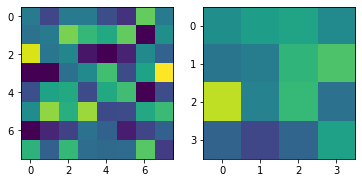

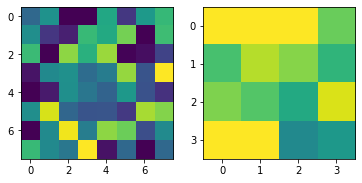

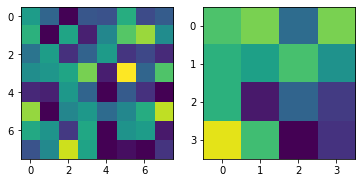

In [107]:
x = rgl.rsample(3)
y, z = rgl.rglayer.encode(x)
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().squeeze(), vmin=-1, vmax=1)